In [15]:
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import hvplot.pandas
import requests_cache
import scipy.stats as stats
from scipy.stats import linregress
# from datetime import datetime, timedelta
from retry_requests import retry

In [16]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [17]:
city_data_path = "../data/city_data.csv"
city_data = pd.read_csv(city_data_path)

In [18]:
# datetime.strftime(datetime.now() - timedelta(3), "%Y-%m-%d")

url = "https://archive-api.open-meteo.com/v1/archive"
res_list = []

city_index = 0
for city in city_data["city"]:
    params = {
        "latitude": city_data["lat"][city_index],
        "longitude": city_data["lon"][city_index],
        "start_date": "2022-01-01",
        "end_date": "2022-12-31",
        "hourly": "temperature_2m",
        "daily": "temperature_2m_mean",
        "temperature_unit": "fahrenheit",
        "timezone": "auto",
    }
    res_list.append(openmeteo.weather_api(url, params=params))
    city_index += 1

city_index = 0
data_list = []
for res in res_list:
    hourly = res[0].Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s"),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["temperature_2m"] = hourly_temperature_2m

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    daily = res[0].Daily()
    daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s"),
            end=pd.to_datetime(daily.TimeEnd(), unit="s"),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["city"] = city_data["city"][city_index]

    daily_dataframe = pd.DataFrame(data=daily_data)

    data_list.append(daily_dataframe)

    city_index += 1

data_con = pd.concat(data_list)

data_merge = data_con.merge(city_data, how="inner", on="city")

In [19]:
temperature_sum_by_city = data_merge.groupby("city")["temperature_2m_mean"].mean()

data_merge = city_data.merge(temperature_sum_by_city, how="right", on="city")

data_merge.replace(to_replace="Hong Kong S.A.R.", value="China", inplace=True)

In [20]:
data_merge.to_csv("../data/weather_data.csv", index=False)

In [21]:
us = data_merge.loc[data_merge["country"] == "United States"]

us = pd.DataFrame(us)

bins = [18, 40, 72]
labels = ["Southern US", "Northern US"]
us["lat_bin"] = pd.cut(
    us["lat"], bins, labels=labels
)

us["lat_bin"].value_counts()

lat_bin
Southern US    42
Northern US    18
Name: count, dtype: int64

In [22]:
us_crime_map = us.hvplot.points(
    "lon",
    "lat",
    geo=True,
    tiles="OSM",
    frame_width=700,
    frame_height=500,
    s="crime_index",
    c="crime_index",
    scale=2,
    alpha=0.9,
    hover=True,
    hover_cols=["lon", "lat", "city", "crime_index"],
)

# hvplot.save(crime_index_map_plot, "../data/crime_index_map.html")

us_crime_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (crime_index,city)

In [23]:
us_temp_map = us.hvplot.points(
    "lon",
    "lat",
    geo=True,
    tiles="OSM",
    frame_width=700,
    frame_height=500,
    s="temperature_2m_mean",
    c="temperature_2m_mean",
    scale=2,
    alpha=0.9,
    hover=True,
    hover_cols=["lon", "lat", "city", "temperature_2m_mean"],
)

# hvplot.save(crime_index_map_plot, "../data/crime_index_map.html")

us_temp_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (temperature_2m_mean,city)

The r-squared is: 0.12882830500813564


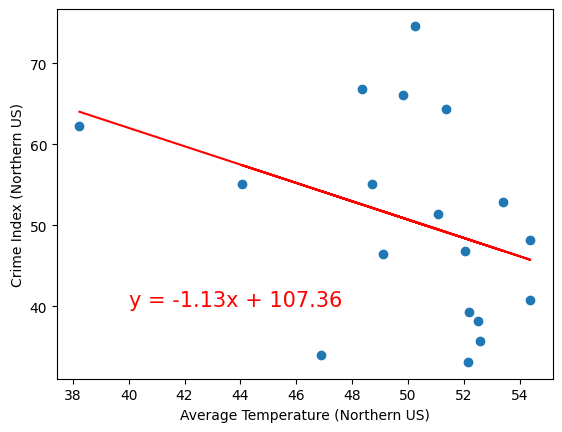

In [24]:
x_values = us["temperature_2m_mean"].loc[us["lat_bin"] == "Northern US"]
y_values = us["crime_index"].loc[us["lat_bin"] == "Northern US"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (40, 40), fontsize=15, color="red")
plt.xlabel("Average Temperature (Northern US)")
plt.ylabel("Crime Index (Northern US)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.008932637280915468


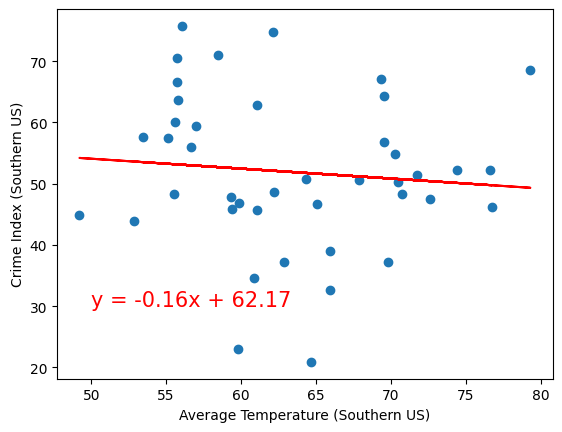

In [25]:
x_values = us["temperature_2m_mean"].loc[us["lat_bin"] == "Southern US"]
y_values = us["crime_index"].loc[us["lat_bin"] == "Southern US"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (50, 30), fontsize=15, color="red")
plt.xlabel("Average Temperature (Southern US)")
plt.ylabel("Crime Index (Southern US)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

F_onewayResult(statistic=0.1353006888682242, pvalue=0.7143371612781761)

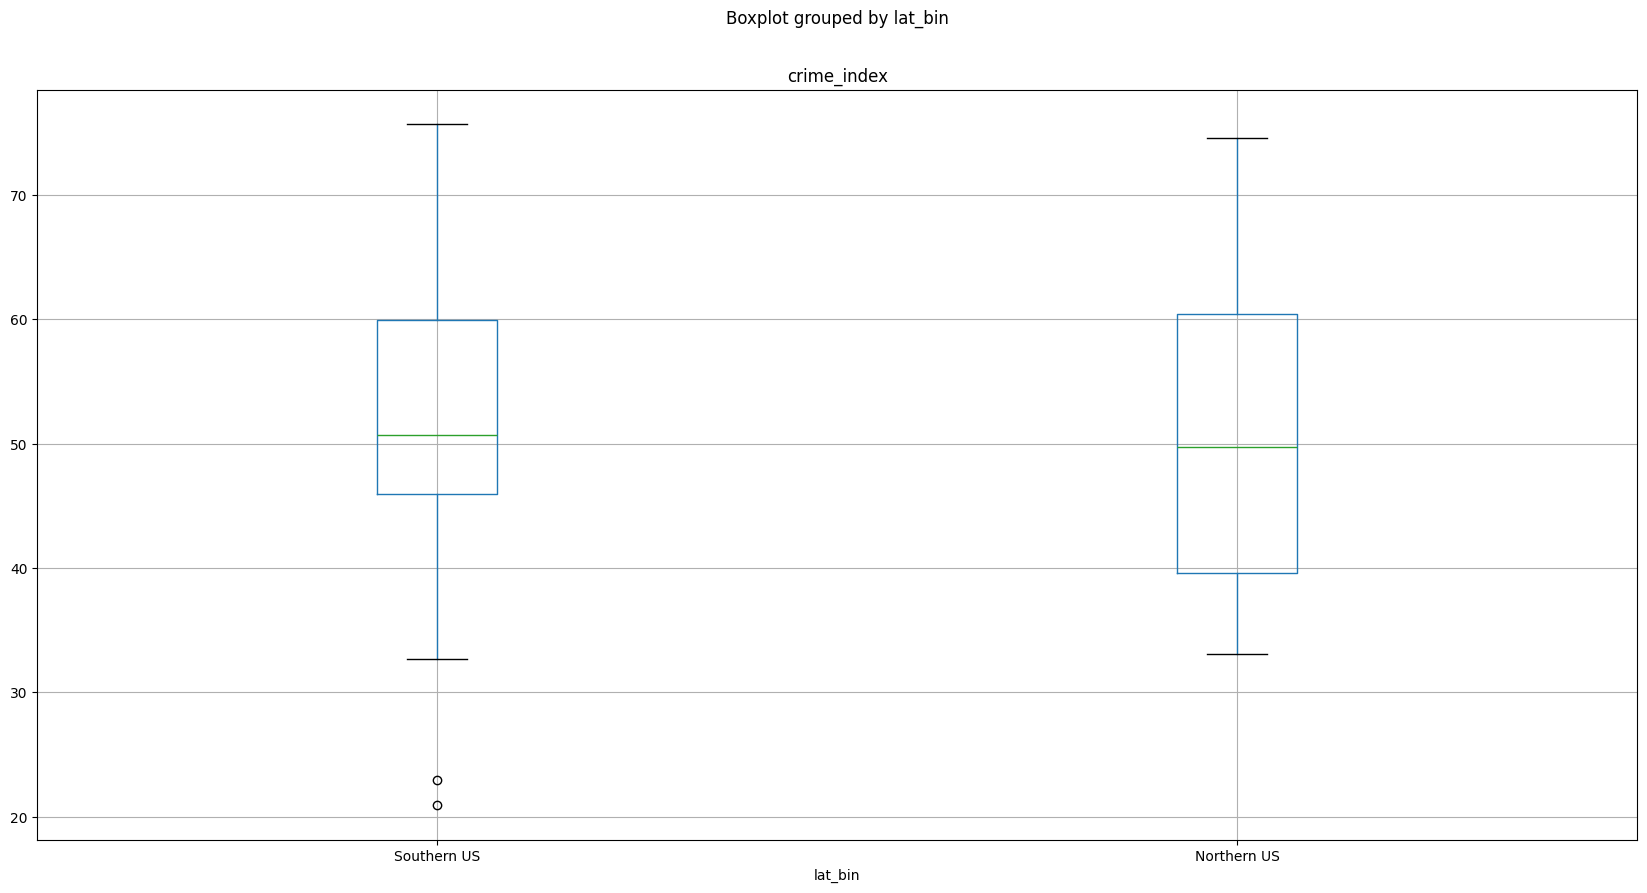

In [43]:
northern_us = us.loc[us["lat_bin"] == "Northern US"]
southern_us = us.loc[us["lat_bin"] == "Southern US"]

us.boxplot("crime_index", by="lat_bin", figsize=(20, 10))
stats.f_oneway(northern_us["crime_index"], southern_us["crime_index"])

In [26]:
mean_temp_hist = data_merge.hvplot.hist("temperature_2m_mean")

mean_temp_hist

:Histogram   [temperature_2m_mean]   (temperature_2m_mean_count)

In [27]:
crime_index_hist = data_merge.hvplot.hist("crime_index")

crime_index_hist

:Histogram   [crime_index]   (crime_index_count)

The r-squared is: 0.02647214945425883


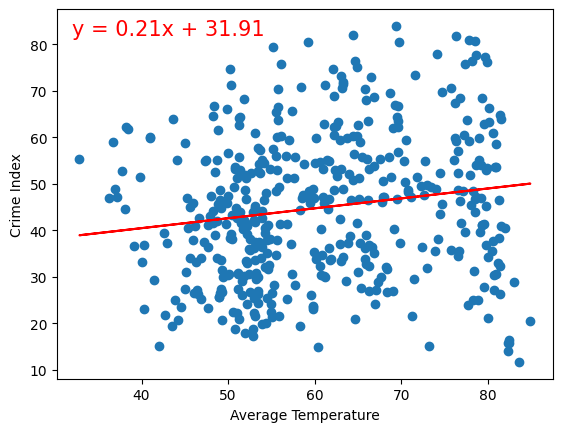

In [28]:
x_values = data_merge["temperature_2m_mean"]
y_values = data_merge["crime_index"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (32, 82), fontsize=15, color="red")
plt.xlabel("Average Temperature")
plt.ylabel("Crime Index")
print(f"The r-squared is: {rvalue**2}")
plt.show()